In [ ]:
!pip install numpy pandas seaborn opencv-python tqdm scipy

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from tqdm import tqdm
from scipy.stats import multinomial
# sns.set()

## Training data

In [2]:
input_dir = os.path.normpath('../data/train_data')
train_data = 'train_task_3_4.csv'
data_path = os.path.join(input_dir, train_data)
train_df = pd.read_csv(data_path)
train_df

,QuestionId,UserId,AnswerId,IsCorrect,CorrectAnswer,AnswerValue
0,898,2111,280203,1,2,2
1,767,3062,55638,1,3,3
2,165,1156,386475,1,2,2
3,490,1653,997498,1,4,4
4,298,3912,578636,1,3,3
...,...,...,...,...,...,...
1382722,80,2608,57945,1,2,2
1382723,707,2549,584230,0,2,1
1382724,840,5901,1138956,1,1,1
1382725,794,3854,1151183,0,1,3


In [3]:
QUESTION_KEY = 'QuestionId'
n_questions = len(train_df[QUESTION_KEY].unique())
n_questions

948

## Feature 1: Selection entropy

In [4]:
selection_entropies = train_df.groupby(QUESTION_KEY)['AnswerValue'].agg(
    lambda x: multinomial.entropy(1, x.value_counts(normalize=True))
)
selection_entropies

QuestionId
0      1.194456
1      0.876006
2      1.331663
3      0.695423
4      1.324321
         ...   
943    0.958544
944    1.312404
945    1.260934
946    1.236733
947    1.082614
Name: AnswerValue, Length: 948, dtype: float64

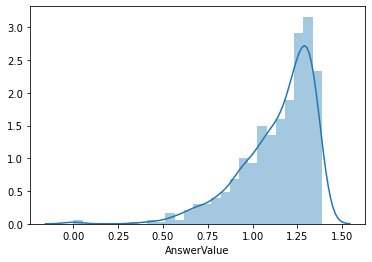

In [5]:
sns.distplot(selection_entropies)

## Feature 2: Correct/Wrong entropy

In [6]:
correctness_entropies = train_df.groupby(QUESTION_KEY)['IsCorrect'].agg(
    lambda x: multinomial.entropy(1, x.value_counts(normalize=True))
)

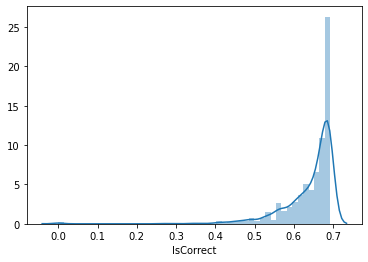

In [7]:
sns.distplot(correctness_entropies)

## Feature 3: Difficulty

In [8]:
user2score = {
    user_id: correct_rate for user_id, correct_rate \
        in train_df.groupby('UserId')['IsCorrect'].mean().reset_index().values
}
train_df['UserCorrectRate'] = train_df['UserId'].map(user2score)

l_question_ids = [None] * n_questions
l_difficulties = [None] * n_questions
for i, (question_id, gpby_df) in enumerate(train_df.groupby(QUESTION_KEY)):
    mean_diff = (gpby_df['IsCorrect'] - gpby_df['UserCorrectRate']).abs().mean()
    l_question_ids[i] = question_id
    l_difficulties[i] = mean_diff
question_ids = pd.Series(l_question_ids, name=QUESTION_KEY)
difficulties = pd.Series(l_difficulties, index=question_ids, name='Difficulty')

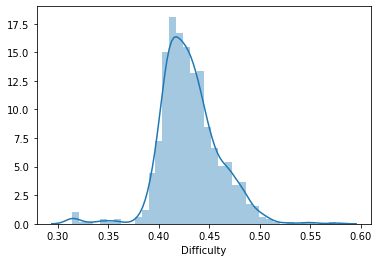

In [9]:
sns.distplot(difficulties)

## Feature 4: Readability

In [10]:
def calc_text_area(points):
    x = abs(points[4] - points[0])
    y = abs(points[5] - points[1])
    return x * y

In [11]:
def calc_area(filepath):
    img = cv2.imread(filepath)
    return img.shape[0] * img.shape[1]

In [12]:
def show_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

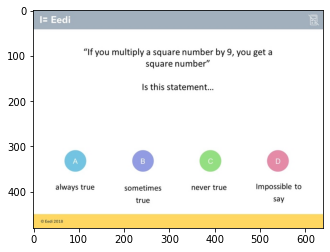

In [13]:
img_dirpath = '../data/images'
show_img(os.path.join(img_dirpath, '0.jpg'))

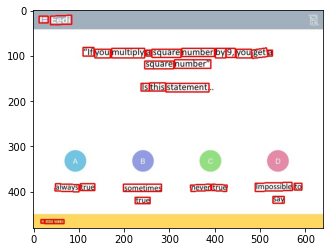

In [14]:
segmentation_result_dirpath = '../data/images_text-segmentation'
show_img(os.path.join(segmentation_result_dirpath, 'res_0.jpg'))


In [15]:
txt_filepaths = [
    os.path.join(segmentation_result_dirpath, filename) \
        for filename in os.listdir(segmentation_result_dirpath) \
        if os.path.splitext(filename)[1] == '.txt'
]
questionid_imgpath_dict = {
    int(filename.split('.')[0]): os.path.join(img_dirpath, filename) \
        for filename in os.listdir(img_dirpath)
}

In [16]:
questionid_rate_dict = {}
for i, filepath in enumerate(tqdm(txt_filepaths)):
    filename = os.path.basename(filepath)
    question_id = filename[4 : filename.find('.')]
    question_id = int(question_id)
    with open(filepath) as f:
        lines = [line.replace('\n', '') for line in f.readlines()]
    text_area = 0
    for line in lines:
        points = line.split(',')
        points = np.array(points).astype('int16')
        text_area += calc_text_area(points)
    text_area_rate = text_area / calc_area(questionid_imgpath_dict[question_id])
    questionid_rate_dict[question_id] = text_area_rate
question_ids = pd.Series(np.arange(n_questions), name=QUESTION_KEY)
sorted_text_area_rates = [questionid_rate_dict[question_id] for question_id in question_ids]
readabilities = pd.Series(sorted_text_area_rates, index=question_ids, name='Readability')

100%|██████████| 948/948 [00:17<00:00, 54.55it/s]


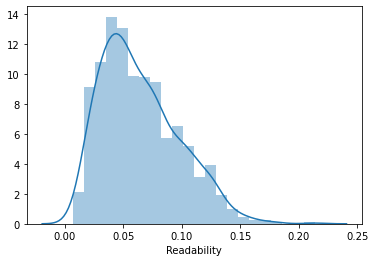

In [17]:
sns.distplot(readabilities)

## Create ranking table

In [18]:
def get_ranking(series, ascending=False):
    return series.rank(method='first', ascending=ascending).astype('int16')

In [19]:
ranking_df = pd.DataFrame()
ranking_df['Feature1_SelectionEntropy'] = get_ranking(selection_entropies)
ranking_df['Feature2_CorrectnessEntropy'] = get_ranking(correctness_entropies)
ranking_df['Feature3_Difficulty'] = get_ranking(difficulties)
ranking_df['Feature4_Readability'] = get_ranking(readabilities)
df_columns = ranking_df.columns.copy()
ranking_df['Feature1+2'] = get_ranking(
    ranking_df[df_columns[:2]].mean(axis='columns'), ascending=True
)
ranking_df['Feature1+2+3'] = get_ranking(
    ranking_df[df_columns[:3]].mean(axis='columns'), ascending=True
)
ranking_df['All'] = get_ranking(
    ranking_df[df_columns[:4]].mean(axis='columns'), ascending=True
)
ranking_df

,Feature1_SelectionEntropy,Feature2_CorrectnessEntropy,Feature3_Difficulty,Feature4_Readability,Feature1+2,Feature1+2+3,All
QuestionId,,,,,,,
0,484,247,458,389,391,434,366
1,844,293,584,776,672,661,728
2,124,481,172,425,230,76,172
3,908,915,751,802,919,924,936
4,150,405,92,440,160,12,113
...,...,...,...,...,...,...,...
943,780,274,634,901,636,656,764
944,188,938,95,410,669,448,393
945,331,324,267,369,296,215,229


## Write submission file

In [20]:
submission_template_dir = os.path.normpath('../submission_templates')
submission_template_file = 'submission_task_3.csv'
output_dir = os.path.normpath('../submissions')
output_file = os.path.normpath('submission_task_3.csv')
if not os.path.isdir(os.path.normpath(output_dir)):
    os.makedirs(os.path.normpath(output_dir))

In [21]:
def write_file(ranking):
    submission_file_path = os.path.join(submission_template_dir, submission_template_file)
    submission_df = pd.read_csv(submission_file_path)
    submission_df['ranking'] = ranking
    output_path = os.path.join(output_dir, output_file)
    submission_df.to_csv(output_path, index=False)

In [22]:
write_file(ranking_df['All'])